* Vers√£o simples de uma Random Forest:

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

Dataset: .. _breast_cancer_dataset:
Dimens√µes: (569, 30)
Vari√°veis: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']...

--- RESULTADOS VERS√ÉO SIMPLES ---
Acur√°cia: 0.9561
N√∫mero de √°rvores: 100
Features por √°rvore: sqrt


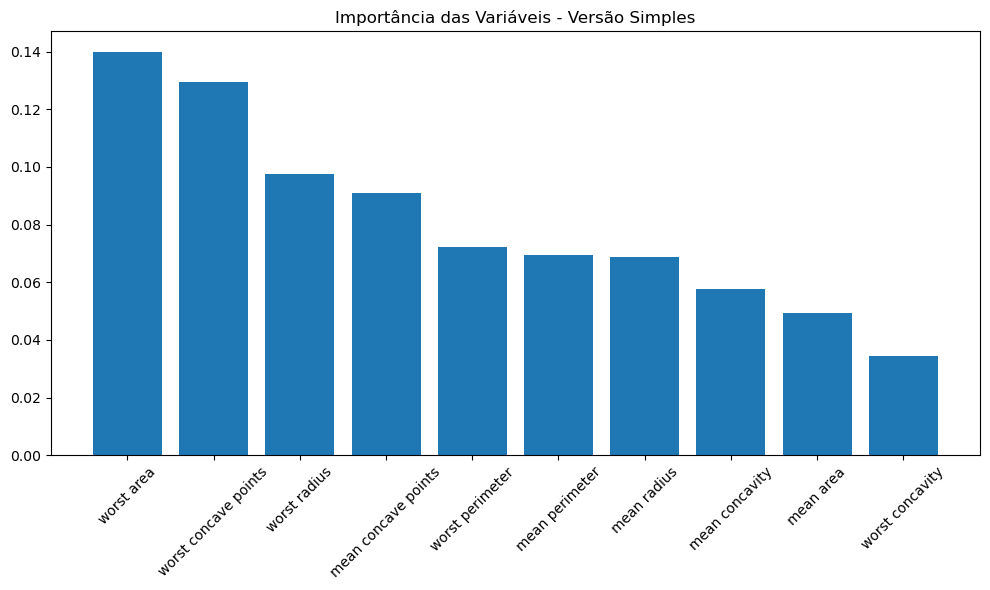


Relat√≥rio de Classifica√ß√£o:
              precision    recall  f1-score   support

   malignant       0.95      0.93      0.94        42
      benign       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [2]:
# 1. Carregar dados (usando dataset de c√¢ncer de mama como exemplo):
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

print(f"Dataset: {data.DESCR.splitlines()[0]}")
print(f"Dimens√µes: {X.shape}")
print(f"Vari√°veis: {list(X.columns[:5])}...")

# 2. Divis√£o treino/teste:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Criar e treinar o modelo - CONFIGURA√á√ÉO SIMPLES:
modelo_simples = RandomForestClassifier(
    n_estimators=100, # N√∫mero de √°rvores (padr√£o)
    random_state=42 # Para reproducibilidade
)

# 4. Treinar e fazer previs√µes e avaliar:
modelo_simples.fit(X_treino, y_treino)
y_pred = modelo_simples.predict(X_teste)
acuracia = accuracy_score(y_teste, y_pred)

print(f"\n--- RESULTADOS VERS√ÉO SIMPLES ---")
print(f"Acur√°cia: {acuracia:.4f}")
print(f"N√∫mero de √°rvores: {len(modelo_simples.estimators_)}")
print(f"Features por √°rvore: {modelo_simples.max_features}")

# 5. Visualiza√ß√£o simples da import√¢ncia das vari√°veis:
importancias = modelo_simples.feature_importances_
indices = np.argsort(importancias)[::-1] # Ordena do maior para o menor

plt.figure(figsize=(10, 6))
plt.title("Import√¢ncia das Vari√°veis - Vers√£o Simples")
plt.bar(range(10), importancias[indices[:10]])  # Top 10 features
plt.xticks(range(10), [data.feature_names[i] for i in indices[:10]], rotation=45)
plt.tight_layout()
plt.show()

# 6. Relat√≥rio de classifica√ß√£o simples:
print("\nRelat√≥rio de Classifica√ß√£o:")
print(classification_report(y_teste, y_pred, target_names=data.target_names))

* Vers√£o Robusta:

In [3]:
# ‚öôÔ∏è 1. Importa√ß√£o e Configura√ß√£o Inicial:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve
)
from sklearn.pipeline import Pipeline

import joblib  # Para salvar o modelo treinado
import warnings
warnings.filterwarnings("ignore")

Formato do dataset: (569, 30)
Classes: [0 1]
Acur√°cia inicial: 0.956140350877193
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Melhores par√¢metros encontrados:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

--- M√âTRICAS DO MODELO FINAL ---
Acur√°cia: 0.956140350877193
ROC-AUC: 0.9932208994708995

Relat√≥rio de Classifica√ß√£o:
              precision    recall  f1-score   support

   malignant       0.95      0.93      0.94        42
      benign       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



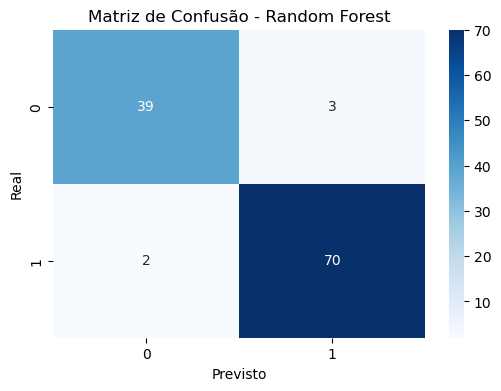

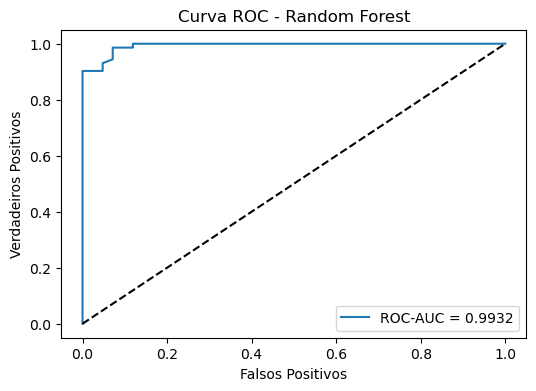

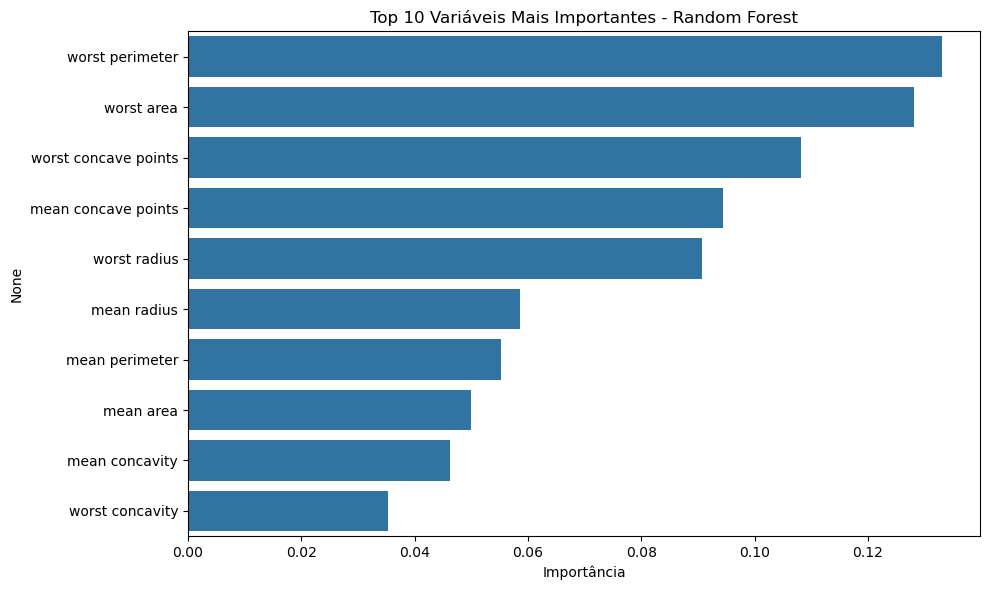

‚úÖ Modelo e scaler salvos com sucesso!


In [4]:
# üìä 2. Carregar e Preparar os Dados

from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

print("Formato do dataset:", X.shape)
print("Classes:", np.unique(y))

# üßπ 3. Pr√©-processamento

# Divis√£o treino/teste:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Padroniza√ß√£o das vari√°veis num√©ricas:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# üå≥ 4. Modelo Base e Treinamento Inicial

modelo_base = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1 # Usa todos os n√∫cleos dispon√≠veis
)

modelo_base.fit(X_train_scaled, y_train)

# Avalia√ß√£o inicial:
y_pred_base = modelo_base.predict(X_test_scaled)
print("Acur√°cia inicial:", accuracy_score(y_test, y_pred_base))

# üß† 5. Ajuste de Hiperpar√¢metros (Grid Search)

parametros = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=modelo_base,
    param_grid=parametros,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=2
)

grid_search.fit(X_train_scaled, y_train)

print("Melhores par√¢metros encontrados:")
print(grid_search.best_params_)

melhor_modelo = grid_search.best_estimator_

# üìà 6. Avalia√ß√£o do Modelo Otimizado

y_pred_otimizado = melhor_modelo.predict(X_test_scaled)
y_proba_otimizado = melhor_modelo.predict_proba(X_test_scaled)[:, 1]

print("\n--- M√âTRICAS DO MODELO FINAL ---")
print("Acur√°cia:", accuracy_score(y_test, y_pred_otimizado))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_otimizado))
print("\nRelat√≥rio de Classifica√ß√£o:")
print(classification_report(y_test, y_pred_otimizado, target_names=data.target_names))

# üîç 7. Matriz de Confus√£o e Curva ROC

# Matriz de Confus√£o:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_otimizado), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confus√£o - Random Forest")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

# Curva ROC:
fpr, tpr, _ = roc_curve(y_test, y_proba_otimizado)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_score(y_test, y_proba_otimizado):.4f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdadeiros Positivos")
plt.title("Curva ROC - Random Forest")
plt.legend()
plt.show()

# üåø 8. Import√¢ncia das Vari√°veis:
importancias = pd.Series(melhor_modelo.feature_importances_, index=X.columns)
importancias = importancias.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importancias[:10], y=importancias.index[:10])
plt.title("Top 10 Vari√°veis Mais Importantes - Random Forest")
plt.xlabel("Import√¢ncia")
plt.tight_layout()
plt.show()

# üíæ 9. Salvando o Modelo e o Pr√©-processador

# Salva modelo e scaler para uso em produ√ß√£o:
joblib.dump(melhor_modelo, "modelo_random_forest.pkl")
joblib.dump(scaler, "scaler.pkl")
print("‚úÖ Modelo e scaler salvos com sucesso!")